In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import cv2

In [2]:
data_dir = 'C:/CoronaChest/metadata.csv'
df = pd.read_csv(data_dir)


이번에는 이미지는 아니지만 또 다시 COVID-19관련 데이터이다.

하지만 이전에 분석했던 데이터보다 많은 양의 정보 문자열로 이루어진 정보, 그리고 폐x-ray이미지의 이름까지 저장되어 있는 csv파일이다.

이를 통해

1. 성별, 나이, 장소등을 이용해서 생존 여부를 판단(단순한 NN알고리즘으로도 가능할 것 같다.)
2. 우리나라 한정이 아니기 때문에 국적에 따른 생존 여부를 판단
3. 'finding' column에 다양한 코로나 이외의 폐렴류의 질병이 존재하기 때문에 다른 데이터를 이용해서 이를 예측하는 DNN model을 만들어볼 것이다.
4. 다양한 정보들의 상관관계에 대해서 분석을 하면서 시각화를 해볼 생각이다.
5. 최종 목표는 어떤 질병인지('finding')을 알아내는 것이기 때문에 주어진 폐사진은 CNN모델을 이용해서 학습을 해 주어야 한다.
6. 이때 이미지데이터와 csv데이터 모두를 조합해서 어떠한 질병인지 예측하는 것을 해보고 싶었는데 그것을 ensemble로 하면 되는 줄 알았더니 알고 보니 그렇지는 않았다.
7. 일단 이 jupyter notebook에는 CNN을 이용해 학습한 내용만 기록하고 다음에는 csv 정보들만을 이용해 성별, 나이, 장소를 이용해서 생존 여부를 추측하는 과정을 거치고 싶은데 그러기에는 생존 여부가 저장된 샘플의 수가 훨씬 적다. 그래도 성별, 나이, 국적, 코로나여부를 이용해 저장된 샘플로 만이라도 생존 여부를 확인하고 상관관계 파악을 위해 정보 시각화를 연습해보고자 한다.

In [3]:
batch_size = 16
epochs = 100

In [ ]:
df['survival'].value_counts()

In [ ]:
df['location'].value_counts()

In [ ]:
df.info()

object로 데이터가 저장된 것들도 꽤 있지만 그뿐이 아니라 비어있는 부분의 데이터도 꽤 존재한다. 이중에 학습을 시키는데 필요 없는 정보도 꽤 존재한다. 따라서 .drop()을 이용해 제거해 주는 과정도 필요할 것이고 중요한 데이터는 median을 이용해서 매꿔주는 등의 과정을 거칠 필요가 있다.

In [4]:
df['folder'].value_counts()

images     351
volumes     21
Name: folder, dtype: int64

In [5]:
covid_dataset_path = 'C:/CoronaChest'
dataset_path = './dataset'

In [6]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

In [7]:
x_data = []
for (i, row) in df.iterrows():
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])
    if not os.path.exists(imagePath):
        continue
    x_data.append(imagePath)

    

In [8]:
import os
new_size = 128
x_image_data = []
y_image_data = []
for k in range(len(x_data)):
    i = x_data[k]
    if os.path.exists(i):
        img_data = cv2.imread(i, cv2.IMREAD_COLOR)
        img_data = cv2.resize(img_data, (new_size, new_size))
        x_image_data.append(img_data)
        y_image_data.append(df['finding'][k])

In [10]:
for i in range(len(y_image_data)):
    if y_image_data[i] == 'COVID-19, ARDS':
        y_image_data[i] = 'COVID-19'

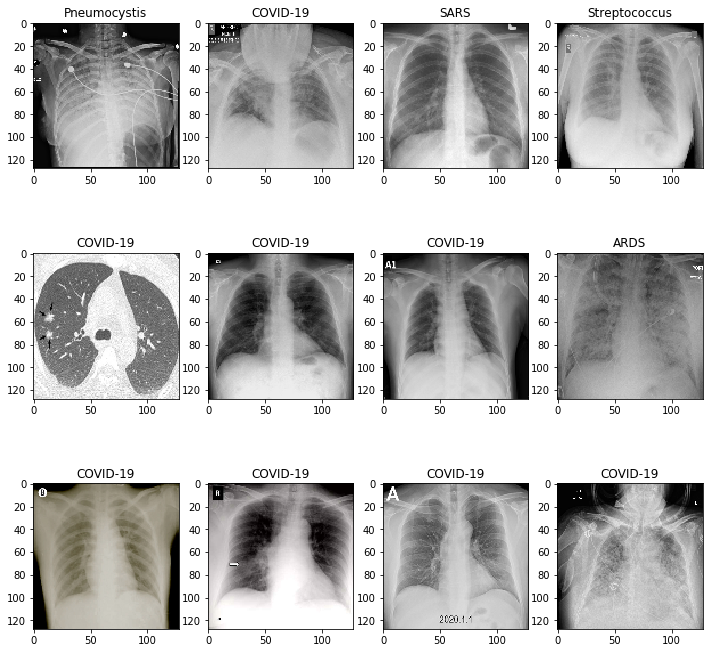

In [11]:
import random
def visual_data():
    choosen = random.sample([int(i) for i in range(351)], 12)
    plt_index = 1
    plt.figure(figsize = (12,12))
    for i in choosen:
        plt.subplot(3,4,plt_index)
        plt.imshow(x_image_data[i])
        plt.title(y_image_data[i])
        plt_index += 1
visual_data()

In [12]:
y_image_dict = dict()
y_image_dict['COVID-19'] = 0
y_image_dict['SARS'] = 0
y_image_dict['Pneumocystis'] = 0
y_image_dict['Streptococcus'] = 0
y_image_dict['ARDS'] = 0
y_image_dict['No Finding'] = 0
y_image_dict['Chlamydophila'] = 0
y_image_dict['E.Coli'] = 0
y_image_dict['Klebsiella'] = 0
y_image_dict['Legionella'] = 0
for i in y_image_data:
    y_image_dict[i] += 1
y_image_dict
        

{'COVID-19': 287,
 'SARS': 16,
 'Pneumocystis': 15,
 'Streptococcus': 17,
 'ARDS': 4,
 'No Finding': 3,
 'Chlamydophila': 2,
 'E.Coli': 4,
 'Klebsiella': 1,
 'Legionella': 2}

나온 결과를 보니 COVID-19와 SARS이외에도 다양한 질병이 있었고, 이것들을 모두 분류하는 것은 의미도 없고 표본 개수 차이가 너무 많이 나서 학습이 어려울 것이라고 판단을 했다. 그래서 COVID-19데이터 제외 나머지는 SAFE로 바꿀 예정이다.

결국에 class의 최종 개수는 2개가 되어서 model.compile과정에서 loss를 'binary_classification'으로 설정해야 할 것이다.

In [13]:
for i in range(len(y_image_data)):
    if y_image_data[i] != 'COVID-19':
        y_image_data[i] = 'SAFE'

그리고 위에서 다시 image를 불러보니까 제대로 바뀌어 있었고, 뭔가 매번 위로 올라가서 이미지를 불러오기 번거로울 것 같아서 visual_data()라는 함수를 정의했다.

주어진 폐의 이미지의 directory를 os를 이용해서 구했고, 사실 이렇게 파일을 다운받고 분석이 가능하도록 고치는 과정이 제일 어렵다고 생각한다. 이 과정에서 많이 배웠는데, 특히 python의 자료를 입력받는 방법중에 하나인 os에 대해서 더 정확하게 알 수 있었다고 생각한다.

이후 x_image_data와 y_image_data의 형태를 바꿔주었다.

In [14]:
x_image_data = np.array(x_image_data, dtype = 'float32').reshape(-1, new_size, new_size, 3)

y_image_data = np.asarray(y_image_data).reshape(351)

x_image_data.shape[0]

351

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
index = np.arange(x_image_data.shape[0])
np.random.shuffle(index)
x_image_data = x_image_data[index]
y_image_data = y_image_data[index]
y_image_cat = label_encoder.fit_transform(y_image_data)

(x_image_train, x_image_test, y_image_train, y_image_test) = train_test_split(x_image_data, y_image_cat, test_size=0.2, random_state=None, shuffle= False, stratify=None) 
(x_image_train, x_image_val , y_image_train, y_image_val ) = train_test_split(x_image_train, y_image_train, test_size=0.25, random_state=None, shuffle = False, stratify=None)


In [ ]:
x_image_test

In [ ]:
y_image_cat

In [30]:
len(y_image_cat), len(x_image_data)

(351, 351)

원하는대로 이미지 데이터와 label까지 마무리 지었으니, 그리고 두 정보의 개수까지 일치하니 이제는 학습을 위한 사진 처리 과정과 시각화 등의 과정을 거칠 때가 된것 같다. 

이 문제 또한 이미지 관련 데이터 분석과 학습이기 때문에 CNN 네트워크를 사용하면 될것으로 예상된다.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    zoom_range = 0.3,
    shear_range = 0.5,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    horizontal_flip = True,
    vertical_flip = False
)

test_image_generator = ImageDataGenerator(
    rescale = 1./255
)

val_image_generator = ImageDataGenerator(
    rescale = 1./255
)

In [17]:
train_image_generator.fit(x_image_train)
train_data = train_image_generator.flow(
    x_image_train, y_image_train, batch_size = batch_size
)

test_data = test_image_generator.flow(
    x_image_test, y_image_test, batch_size = batch_size
)

val_data = val_image_generator.flow(
    x_image_val, y_image_val, batch_size = batch_size
)


ImageDataGenerator에 대해 내가 잘 모르는 부분이 있었는데, 알고 보니 flow를 하는 방법도 다양했었던 것이다.

만약에 변형하고 싶은 데이터의 형태가 tensor image data의 형태, 즉 지금과 같은 경우에는 설정한 ImageDataGenerator의 이름이 generator이라면 generator.flow(x_data, y_data, batch_size)를 해주고

변형하고 싶은 형태가 directory에 담긴 이미지라면 generator.flow_from_directory(directory, target_size = (,),color_mode = 'rgb', batch_size = BATCH_SIZE, 등)의 방법으로,

마지막으로 pandas dataframe의 형태라면 generator.flow_from_dataframe(dataframe, directory = '', target_size = (,), batch_size= BATCH_SIZE, class_mode = ''등)의 방법으로 실행한다.

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32, input_shape = (128,128,3), kernel_size = 3, activation = 'relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.Conv2D(filters =128, kernel_size = 3, activation = 'relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.3))
model.add(tf.keras.layers.Dense(units = 2, activation = 'sigmoid'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)      

In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100)
reduce_on = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 10, verbose = 1, mode = 'max', min_lr = 0.000001)
sgd_optimizer = tf.keras.optimizers.SGD(lr = 1e-3, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(
    optimizer = sgd_optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
lasthistory = model.fit_generator(
    train_data, steps_per_epoch = len(x_image_train)//batch_size, epochs = 30, validation_data = val_data, callbacks = [early_stop,reduce_on]
)

Epoch 1/30
13/13 [==============================] - 5s 380ms/step - loss: 0.7507 - accuracy: 0.5412 - val_loss: 0.6532 - val_accuracy: 0.8000
Epoch 2/30
13/13 [==============================] - 5s 373ms/step - loss: 0.5088 - accuracy: 0.7732 - val_loss: 0.6329 - val_accuracy: 0.8000
Epoch 3/30
13/13 [==============================] - 5s 388ms/step - loss: 0.5943 - accuracy: 0.8144 - val_loss: 0.6554 - val_accuracy: 0.8000
Epoch 4/30
13/13 [==============================] - 6s 464ms/step - loss: 0.6480 - accuracy: 0.7933 - val_loss: 0.6672 - val_accuracy: 0.7857
Epoch 5/30
13/13 [==============================] - 6s 448ms/step - loss: 0.5253 - accuracy: 0.7990 - val_loss: 0.6589 - val_accuracy: 0.7857
Epoch 6/30
13/13 [==============================] - 6s 444ms/step - loss: 0.5281 - accuracy: 0.8247 - val_loss: 0.6537 - val_accuracy: 0.8000
Epoch 7/30
13/13 [==============================] - 6s 428ms/step - loss: 0.6036 - accuracy: 0.8000 - val_loss: 0.6198 - val_accuracy: 0.8000
Epoch 

5/5 [==============================] - 0s 89ms/step - loss: 0.5650 - accuracy: 0.8310


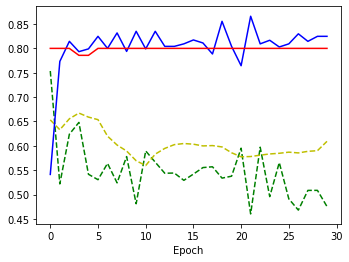

In [28]:
model.evaluate(test_data)
plt.figure(figsize = (12,4))
plt.subplot(1,2,2)
plt.plot(lasthistory.history['loss'], 'g--', label = 'loss')
plt.plot(lasthistory.history['val_loss'], 'y--', label = 'val_loss')
plt.plot(lasthistory.history['accuracy'], 'b-', label = 'accuracy')
plt.plot(lasthistory.history['val_accuracy'], 'r-', label = 'val_accuracy')

plt.xlabel('Epoch')
plt.show()

위와같이 시각화를 하고 나니 꽤 괜찮은 결과가 나왔다.

loss는 점점 감소하고 accuracy는 점점 증가했는데, 사실 epoch수를 100에서 30으로 줄였기 때문일 수도 있다. 

그러나 어쨌든 accuracy는 test_data로 해본 결과 78.87%로 꽤 높게 도출이 되었다.

그러다 stackoverflow를 검색해본 결과 overfitting이 충분히 발생했을 것이라는 생각이 들어(데이터의 양에 비해서 너무 복잡한 모델이었을수도 있겠다) 중간중간에 dropoutlayer을 더 많이 추가해 주었더니 오히려 이전보다 높은 accuracy인 83.10이 나왔으며 val_loss와 loss모두 감소하는경향을 보였다.

In [26]:
predict_data = model.predict(x_image_test/255.0)
predict_data.reshape(142,)
for i in range(71):
    for j in range(2):
        if predict_data[i][j] < 0.5:predict_data[i][j] = 0
        else:predict_data[i][j] = 1
predict_datda = np.ravel(predict_data,order= 'C')

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(
    optimizer = rmsprop_optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_data, steps_per_epoch = len(x_image_train)//batch_size, epochs = epochs, validation_data = val_data, callbacks = [early_stop]
)

In [ ]:
model.evaluate(test_data)

정확도가 나름 81.69%대로 높게 나왔다고 생각한다.

그러나 조금더 정확도를 높이고 싶어서 callback에 ReduceLROnPlatequ라는 함수를 하나 더 이용하고자한다. 관찰중인 값에 변화가 없을 경우에 learning_rate를 조정하는 역할을 한다.


In [ ]:
reduce_on = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 10, verbose = 1, mode = 'min', min_lr = 0.000001)

In [ ]:
newhistory = model.fit(
    train_data, steps_per_epoch = len(x_image_train)//batch_size, epochs = epochs, validation_data = val_data, callbacks = [early_stop,reduce_on]
)

In [ ]:
model.evaluate(test_data)

결론적으로 loss는 줄었지만 accuracy에는 큰 변화가 없는 것 같다.

이제 예측과 학습 결과를 시각화해 보고자 한다.

In [32]:
predict_data = model.predict(x_image_test/255.0)

In [34]:
y_image_test

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0], dtype=int64)

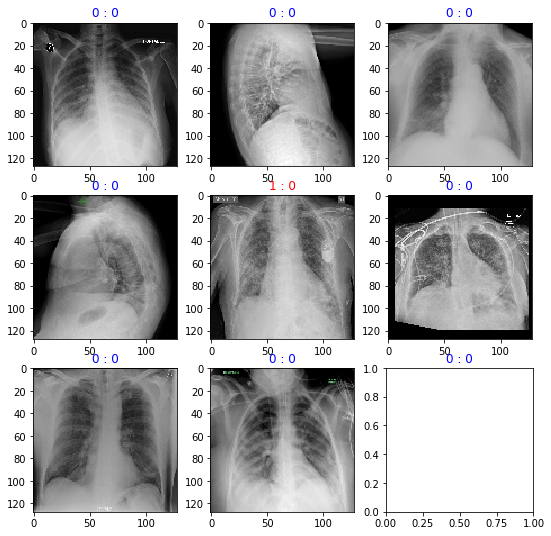

In [35]:
plt.figure(figsize = (9,9))
plt_index = 1
choice = np.random.choice([int(i) for i in range(70)], 9, replace = False)
for i in choice:
    plt.imshow(x_image_data[i]/255.0)
    plt.subplot(3,3,plt_index)
    a, b = y_image_test[i], int(predict_data[i][1])
    if a == b:
        plt.title('%s : %s'%(y_image_test[i], int(predict_data[i][1])), color = 'blue')
    else:
        plt.title('%s : %s'%(a,b), color = 'red')
    plt_index += 1
    
    

In [ ]:
plt.figure(figsize = (12,12))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'g-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss_1')
plt.plot(newhistory.history['val_loss'], 'b-.', label = 'val_loss_2')
plt.xlabel('Epoch')
plt.ylim(0.4,0.6)
plt.show()

plt.figure(figsize = (12,4))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label = 'val_accuracy_1')
plt.plot(newhistory.history['val_accuracy'], 'b-.', label = 'val_accuracy_2')
plt.xlabel('Epoch')
plt.show()


val_accuracy는 계속해서 증가하지도 않고 0.8로 일정한 모습을 보이는 것으로 보아 뭔가가 잘못된것 같다.

그리고 무엇보다 val_loss_1의 값은 어느정도 추이가 일정한데에 반해 val_loss_2의 값은 감소하는 듯 하다 증가하려는 과적합 증상을 보일것도 같다.

그래서 compiling할 때의 optimizer을 SGD로 바꾸어서 다시 시행해 보았다. 아무래도 class의 개수가 2개이다 보니 이게 맞을것도 같았다.

그러나 결과적으로는 오히려 SGD로 optimizer을 설정했을 때의 정확도는 45.67%로 터무니 없이 낮았고, 따라서 Adam으로 바꾸오 learning_rate 를 0.0001로 바꾸어 주었더니 시도해 본 것들 중에는 최적의 결과가 나왔다.

그 이전에는 계속 val_accuracy가 일정하다는 문제가 있었으니 올바른 학습으로 간주할수 없었다.